# Dataset

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Creating a empty dict, where I will save all parameters required for test data transformation

saved_dict = {}

In [4]:
# Reading datasets
dfs = []

from google.colab import drive
drive.mount('/content/drive')


for i in range(1,5):
  path = '/content/drive/MyDrive/UNSW/UNSW-NB15/UNSW-NB15_{}.csv'
  dfs.append(pd.read_csv(path.format(i), header = None))

print(dfs)
all_data = pd.concat(dfs).reset_index(drop=True)
print(type(all_data))
print(all_data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[                0      1              2      3    4    5         6      7   \
0       59.166.0.0   1390  149.171.126.6     53  udp  CON  0.001055    132   
1       59.166.0.0  33661  149.171.126.9   1024  udp  CON  0.036133    528   
2       59.166.0.6   1464  149.171.126.7     53  udp  CON  0.001119    146   
3       59.166.0.5   3593  149.171.126.5     53  udp  CON  0.001209    132   
4       59.166.0.3  49664  149.171.126.0     53  udp  CON  0.001169    146   
...            ...    ...            ...    ...  ...  ...       ...    ...   
699996  59.166.0.8  12520  149.171.126.6  31010  tcp  FIN  0.020383    320   
699997  59.166.0.0  18895  149.171.126.9     80  tcp  FIN  1.402957  19410   
699998  59.166.0.0  30103  149.171.126.5   5190  tcp  FIN  0.007108   2158   
699999  59.166.0.6  30388  149.171.126.5    111  udp  CON  0.004435    568   
700000  59.1

In [5]:
# This csv file contains names of all the features
df_col = pd.read_csv('/content/drive/MyDrive/UNSW/UNSW-NB15/NUSW-NB15_features.csv', encoding='ISO-8859-1')

In [6]:
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [7]:
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']
print(all_data)

Name            srcip  sport           dstip dsport proto state       dur  \
0          59.166.0.0   1390   149.171.126.6     53   udp   CON  0.001055   
1          59.166.0.0  33661   149.171.126.9   1024   udp   CON  0.036133   
2          59.166.0.6   1464   149.171.126.7     53   udp   CON  0.001119   
3          59.166.0.5   3593   149.171.126.5     53   udp   CON  0.001209   
4          59.166.0.3  49664   149.171.126.0     53   udp   CON  0.001169   
...               ...    ...             ...    ...   ...   ...       ...   
2540042    59.166.0.5  33094   149.171.126.7  43433   tcp   FIN  0.087306   
2540043    59.166.0.7  20848   149.171.126.4     21   tcp   CON  0.365058   
2540044    59.166.0.3  21511   149.171.126.9     21   tcp   CON  6.335154   
2540045    59.166.0.9  35433   149.171.126.0     80   tcp   CON  2.200934   
2540046  175.45.176.0  17293  149.171.126.17    110   tcp   CON  0.942984   

Name     sbytes  dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst  \
0

In [8]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()
print(saved_dict)

{'columns': ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat']}


In [9]:
del df_col

In [10]:
all_data.shape

(2540047, 49)

In [11]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [12]:
train, test = train_test_split(all_data, test_size=0.3, random_state=16)

In [13]:
del all_data

In [14]:
print(train.shape,'\n',test.shape)

(1778032, 49) 
 (762015, 49)


In [15]:
# checking for null values
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [19]:
# Delete Null values
train = train.dropna()
print(train.isnull().sum())

Name
srcip               0
sport               0
dstip               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
stime               0
ltime               0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct_src_dport_ltm    0
ct_ds

In [21]:
# checking for null values
test.isnull().sum()

Name
srcip                    0
sport                    0
dstip                    0
dsport                   0
proto                    0
state                    0
dur                      0
sbytes                   0
dbytes                   0
sttl                     0
dttl                     0
sloss                    0
dloss                    0
service                  0
sload                    0
dload                    0
spkts                    0
dpkts                    0
swin                     0
dwin                     0
stcpb                    0
dtcpb                    0
smeansz                  0
dmeansz                  0
trans_depth              0
res_bdy_len              0
sjit                     0
djit                     0
stime                    0
ltime                    0
sintpkt                  0
dintpkt                  0
tcprtt                   0
synack                   0
ackdat                   0
is_sm_ips_ports          0
ct_state_ttl           

In [22]:
# Delete Null values
test = test.dropna()
print(test.isnull().sum())

Name
srcip               0
sport               0
dstip               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
stime               0
ltime               0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct_src_dport_ltm    0
ct_ds

In [23]:
train['attack_cat'].value_counts()

attack_cat
Generic           5240
Exploits          3812
 Fuzzers          3569
Reconnaissance    1220
DoS                829
Backdoors          374
Analysis           372
Shellcode          151
Worms               18
Name: count, dtype: int64

In [24]:
# We don't have "normal" values for "attack_cat", so we must fill Null values with "normal"
train['attack_cat'] = train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [25]:
train['attack_cat'].value_counts()

attack_cat
generic           5240
exploits          3812
fuzzers           3569
reconnaissance    1220
dos                829
backdoors          374
analysis           372
shellcode          151
worms               18
Name: count, dtype: int64

In [26]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

In [27]:
# Even though it's a binary column, but there're values like 2 and 4
train['is_ftp_login'].value_counts()

is_ftp_login
0.0    15551
1.0       34
Name: count, dtype: int64

In [28]:
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [29]:
# There are no Null values in the train data anymore
train.isnull().sum().sum()

0

In [30]:
# Getting name of all the columns
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

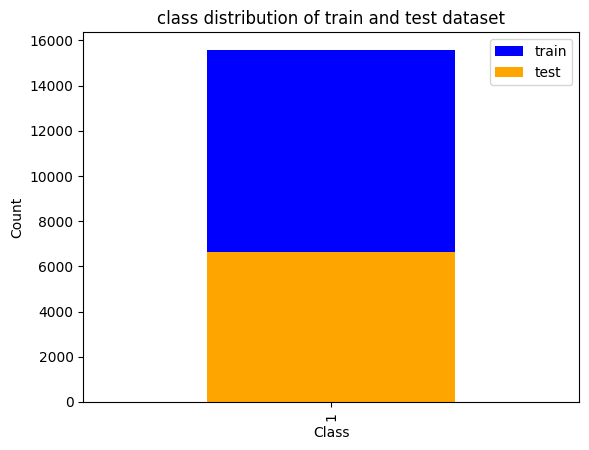

In [33]:
# Plotting target label distribution
plt.figure()
plt.title("class distribution of train and test dataset")
train['label'].value_counts().plot(kind="bar", color='b', label="train")
test['label'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [34]:
# Check if any null value present in datasets
train.isnull().sum().sum(), test.isnull().sum().sum()  # No Null in train and test data is still raw

(0, 0)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15585 entries, 52504 to 27472
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   srcip             15585 non-null  object 
 1   sport             15585 non-null  object 
 2   dstip             15585 non-null  object 
 3   dsport            15585 non-null  object 
 4   proto             15585 non-null  object 
 5   state             15585 non-null  object 
 6   dur               15585 non-null  float64
 7   sbytes            15585 non-null  int64  
 8   dbytes            15585 non-null  int64  
 9   sttl              15585 non-null  int64  
 10  dttl              15585 non-null  int64  
 11  sloss             15585 non-null  int64  
 12  dloss             15585 non-null  int64  
 13  service           15585 non-null  object 
 14  sload             15585 non-null  float64
 15  dload             15585 non-null  float64
 16  spkts             15585 non-null  int64  

In [36]:
# All the datatypes in our dataset
train.dtypes.value_counts()

int64      29
float64    11
object      9
Name: count, dtype: int64

In [37]:
# Categorical feature names
#you're instructing pandas to select columns whose data types are not numeric.
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [38]:
# In the research paper it was mentioned that, this is a numerical feature not a categorical
train['ct_ftp_cmd'].unique()

array([0, 1], dtype=object)

In [39]:
# Removing empty space and converting it to numerical
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [40]:
train['ct_ftp_cmd'].unique()

array([0, 1])

In [41]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object', name='Name')

In [42]:
# Numeric features names
train.select_dtypes(include=np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [43]:
 # Info for test data transformation
saved_dict['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

In [44]:
# see if binary columns are really binary
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(train[col].value_counts())
    print()

is_sm_ips_ports
0    15585
Name: count, dtype: int64

is_ftp_login
0    15551
1       34
Name: count, dtype: int64



In [45]:
# The col "is_ftp_login" has few wrong values like 2, 4. It should only have 0 and 1, If the ftp session is accessed by user and
# password then 1 else 0. Need to fix this.

# Replacing all the values apart from 0 and 1 from these two columns.
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])

In [46]:
train['is_ftp_login'].value_counts()

is_ftp_login
0    15551
1       34
Name: count, dtype: int64

In [47]:
train['service'].value_counts()

service
-           8236
dns         4880
http        1368
smtp         427
ftp          338
pop3         153
ftp-data     142
ssl           19
snmp          11
dhcp           5
radius         4
irc            1
ssh            1
Name: count, dtype: int64

In [48]:
# removing all the "-" and replacing those with "None"
train['service'] = train['service'].apply(lambda x:"None" if x=="-" else x)

In [49]:
train['service'].value_counts()

service
None        8236
dns         4880
http        1368
smtp         427
ftp          338
pop3         153
ftp-data     142
ssl           19
snmp          11
dhcp           5
radius         4
irc            1
ssh            1
Name: count, dtype: int64

In [50]:
# In the research paper there are not 10 unique values
train['attack_cat'].nunique()

9

In [51]:
train['attack_cat'].value_counts()

attack_cat
generic           5240
exploits          3812
fuzzers           3569
reconnaissance    1220
dos                829
backdoors          374
analysis           372
shellcode          151
worms               18
Name: count, dtype: int64

In [52]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [53]:
train.shape, test.shape

((15585, 49), (6630, 49))

In [60]:
train.to_csv('/content/drive/MyDrive/UNSW/UNSW-NB15/Cleaned_UNSW_Trained_Data.txt', index=False)
test.to_csv('/content/drive/MyDrive/UNSW/UNSW-NB15/Cleaned_UNSW_Tested_Data.txt', index=False)